### Big data course project
<strong>T8: Analysis of FHVHV growth</strong>

Jovana Videnovic & Haris Kupinic

In [1]:
import pandas as pd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import os
import duckdb
import geopandas as gpd
import numpy as np
import time
import dask.dataframe as dd
import duckdb
from dask_sql import Context
from dask.distributed import Client, LocalCluster
from pathlib import Path

In [ ]:
vis_path = Path("/d/hpc/home/jv8043/BD/project/T8/T8_vis")

In [3]:
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

plt.rcParams['axes.facecolor']='w'

In [4]:
rides_per_year_path = Path("/d/hpc/home/jv8043/BD/project/T2/T2_tables")
service_types = ["yellow", "fhv", "green", "fhvhv"]

#### Ride share - comaparison yellow, green vs fhvhv

In [14]:
# Load datasets from imaginary paths
yellow_df = pd.read_csv(rides_per_year_path / "yellow" / "rides_per_year.csv")   
# take yellow from 2014
yellow_df = yellow_df[yellow_df["year"] >= 2014]
green_df = pd.read_csv(rides_per_year_path / "green" / "rides_per_year.csv")     
fhvhv_df = pd.read_csv(rides_per_year_path / "fhvhv" / "rides_per_year.csv")     

# Add a 'service' column to each
yellow_df["service"] = "Yellow"
green_df["service"] = "Green"
fhvhv_df["service"] = "FHVHV"

# Combine all data into one DataFrame
all_df = pd.concat([yellow_df, green_df, fhvhv_df], ignore_index=True)

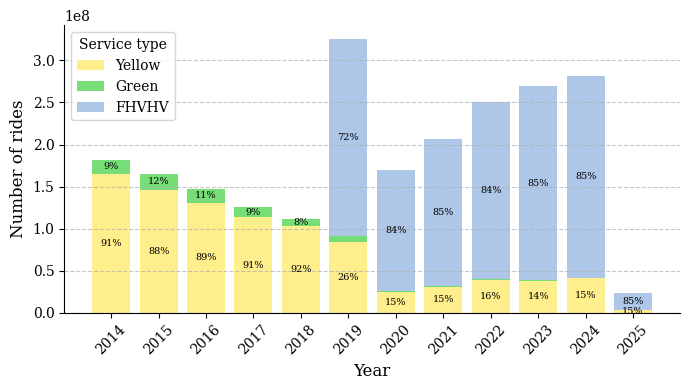

In [59]:
# Combine all data into one DataFrame
all_df = pd.concat([yellow_df, green_df, fhvhv_df], ignore_index=True)

# Define full range of years
all_years = range(all_df["year"].min(), all_df["year"].max() + 1)

# Pivot to get rides per service per year
pivot_df = all_df.pivot(index="year", columns="service", values="rides").fillna(0)
pivot_df = pivot_df.reindex(all_years, fill_value=0)

# Order services
services = ["Yellow", "Green", "FHVHV"]
colors = ["#ffee8c", "#77dd77", "#aec7e8"]
pivot_df = pivot_df[services]

# Compute totals and percentages
totals = pivot_df.sum(axis=1)
percent_df = pivot_df.div(totals, axis=0) * 100

# Plot stacked bar chart
fig, ax = plt.subplots(figsize=(7, 4))

bottom = np.zeros(len(pivot_df))
bars = []
for service, c in zip(services, colors):
    bars.append(ax.bar(pivot_df.index, pivot_df[service], bottom=bottom, label=service, color=c))
    bottom += pivot_df[service]

# Add percentage labels inside bars
for i, year in enumerate(pivot_df.index):
    cumulative_bottom = 0
    for service in services:
        height = pivot_df.loc[year, service]
        if height > 0:
            pct = percent_df.loc[year, service]
            # Only label if segment is big enough (e.g., >3% to avoid clutter)
            if pct > 3:
                ax.text(year, 
                         cumulative_bottom + height / 2, 
                         f"{int(round(pct))}%", 
                         ha='center', va='center', 
                         color='black', fontsize=7, fontweight='normal')
        cumulative_bottom += height

# Set x-axis ticks and labels for every year
ax.set_xticks(ticks=pivot_df.index, labels=pivot_df.index, rotation=45)

# plt.title("Number of Rides per Year by Service with Percentage Shares")
ax.set_xlabel("Year")
ax.set_ylabel("Number of rides")
ax.legend(title="Service type", loc='upper left', ncols=1)
ax.grid(axis='y', linestyle='--', alpha=0.7)
# remove up and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()
plt.show()
fig.savefig(vis_path / "rides_per_year_by_service.pdf", dpi=300, bbox_inches='tight')

#### Analysis of FHVHV shares

In [5]:
part_df_path = Path("/d/hpc/projects/FRI/bigdata/students/jv8043/partitioned_data")
service_type = "fhvhv"

In [6]:
df = dd.read_parquet(part_df_path / service_type, engine="pyarrow", assume_missing=True)

In [7]:
df.columns

Index(['hvfhs_license_num', 'dispatching_base_num', 'originating_base_num',
       'request_datetime', 'on_scene_datetime', 'pickup_datetime',
       'dropoff_datetime', 'pulocationid', 'dolocationid', 'trip_miles',
       'trip_time', 'base_passenger_fare', 'tolls', 'bcf', 'sales_tax',
       'congestion_surcharge', 'airport_fee', 'tips', 'driver_pay',
       'shared_request_flag', 'shared_match_flag', 'access_a_ride_flag',
       'wav_request_flag', 'wav_match_flag', 'pickup_lat', 'pickup_lon',
       'dropoff_lat', 'dropoff_lon'],
      dtype='object')

In [33]:
display(df.head())

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,pulocationid,dolocationid,trip_miles,...,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon
9087,HV0003,B02871,B02871,2019-02-28 23:52:45,2019-02-28 23:57:03,2019-03-01,2019-03-01 00:04:36,188,62,0.79,...,5.39,N,N,N,N,N,40.65061,-73.95387,40.668103,-73.944799
10297,HV0003,B02867,B02867,2019-02-28 23:57:34,2019-02-28 23:57:48,2019-03-01,2019-03-01 00:05:14,76,76,1.26,...,5.39,N,N,N,N,N,40.66643,-73.88269,40.666430,-73.882690
2010,HV0003,B02865,B02865,2019-02-28 23:53:25,2019-02-28 23:59:02,2019-03-01,2019-03-01 00:37:17,88,265,22.66,...,46.67,N,N,N,N,N,40.70770,-74.00830,NaN,NaN
22370,HV0003,B02875,B02875,2019-02-28 23:52:26,2019-02-28 23:54:57,2019-03-01,2019-03-01 00:33:05,148,260,9.23,...,19.19,Y,Y,N,N,N,40.71500,-73.98430,40.753300,-73.906900
23393,HV0003,B02878,B02878,2019-02-28 23:58:23,2019-02-28 23:59:05,2019-03-01,2019-03-01 00:04:48,247,247,0.80,...,5.39,N,N,N,N,N,40.82763,-73.92533,40.827630,-73.925330


In [8]:
hvfhs_num2name = {
"HV0002": "Juno",
"HV0003": "Uber",
"HV0004": "Via",
"HV0005": "Lyft",
}

In [9]:
df['pickup_datetime'] = dd.to_datetime(df['pickup_datetime'], errors='coerce')

# Extract year from pickup_datetime
df['year'] = df['pickup_datetime'].dt.year

# Group by year and hvfhs_license_num and count rides
rides_per_year_license = df.groupby(['year', 'hvfhs_license_num']).size()


In [40]:
result = rides_per_year_license.compute()

In [43]:
result.to_csv(vis_path / "rides_per_year_license.csv", index=True)

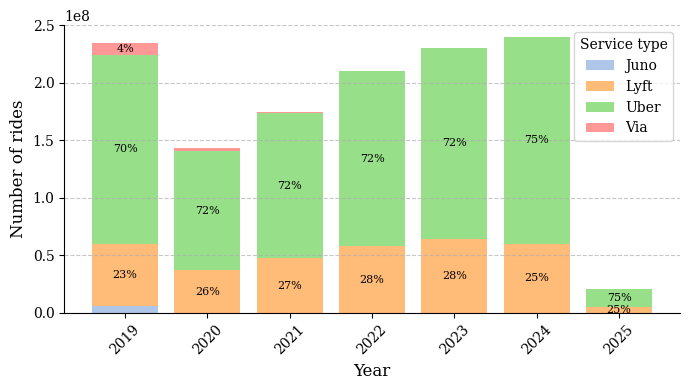

In [60]:
df = pd.read_csv(vis_path / "rides_per_year_license.csv")
df["service"] = df["hvfhs_license_num"].map(hvfhs_num2name)

# Group by year and service
grouped = df.groupby(["year", "service"])["count"].sum().unstack(fill_value=0)

# Create percent version
percent_df = grouped.div(grouped.sum(axis=1), axis=0) * 100

# Plot
fig, ax = plt.subplots(figsize=(7, 4))
services = grouped.columns.tolist()
colors = ["#aec7e8",  # pastel blue for Uber
          "#ffbb78",  # pastel orange for Lyft
          "#98df8a",  # pastel green for Juno
          "#ff9896"]  # pastel red/pink for Via

bottom = np.zeros(len(grouped))
bars = []
for service, color in zip(services, colors):
    bars.append(ax.bar(grouped.index, grouped[service], bottom=bottom, label=service, color=color))
    bottom += grouped[service]

# Add percentage labels inside bars
for i, year in enumerate(grouped.index):
    cumulative_bottom = 0
    for service in services:
        height = grouped.loc[year, service]
        if height > 0:
            pct = percent_df.loc[year, service]
            if pct > 3:  # avoid clutter
                ax.text(year,
                        cumulative_bottom + height / 2,
                        f"{int(round(pct))}%",
                        ha='center', va='center',
                        color='black', fontsize=8, fontweight='normal')
        cumulative_bottom += height

# Format
ax.set_xticks(ticks=grouped.index)
ax.set_xticklabels(grouped.index, rotation=45)
ax.set_xlabel("Year")
ax.set_ylabel("Number of rides")
ax.legend(title="Service type", loc='upper right', ncols=1)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.set_ylim(0, 2.5e8)
# remove up and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()


# Show and optionally save
plt.show()
fig.savefig(vis_path / "rides_per_year_by_fhvhv_service.pdf", dpi=300, bbox_inches='tight')

In [22]:
# Ensure datetime columns are parsed correctly
part_df_path = Path("/d/hpc/projects/FRI/bigdata/students/jv8043/partitioned_data")
service_type = "fhvhv"
df = dd.read_parquet(part_df_path / service_type, engine="pyarrow", assume_missing=True)
df['request_datetime'] = dd.to_datetime(df['request_datetime'])
df['on_scene_datetime'] = dd.to_datetime(df['on_scene_datetime'])

In [23]:
# remove nans from request_datetime and on_scene_datetime
df = df.dropna(subset=['request_datetime', 'on_scene_datetime'])

In [24]:
# filter only rows where on_scene_datetime is after request_datetime
df = df[df['on_scene_datetime'] > df['request_datetime']]

In [25]:
for service_num, service_name in hvfhs_num2name.items():
    if service_num not in ["HV0003"]:  # Uber only
        continue
    # Filter for Uber only
    uber_df = df[df['hvfhs_license_num'] == service_num].copy()

    # Compute waiting time in minutes
    uber_df['waiting_time_min'] = (uber_df['on_scene_datetime'] - uber_df['request_datetime']).dt.total_seconds() / 60
    uber_df = uber_df[uber_df["waiting_time_min"] <= 60]

    # Extract year, weekday, and month
    uber_df['year'] = uber_df['request_datetime'].dt.year
    uber_df['weekday'] = uber_df['request_datetime'].dt.weekday  # Monday = 0
    uber_df['month'] = uber_df['request_datetime'].dt.month

    # Define a function to map month to season
    def month_to_season(month):
        if month in [12, 1, 2]:
            return 'Winter'
        elif month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        else:
            return 'Fall'

    # Apply season transformation using map_partitions
    uber_df['season'] = uber_df.map_partitions(
        lambda df: df['month'].apply(month_to_season),
        meta=('season', 'object')
    )

    # === Compute summaries ===

    # 1. Average waiting time by year
    waiting_by_year = (
        uber_df.groupby('year')['waiting_time_min']
        .mean()
        .compute()
        .reset_index()
    )

    # 2. Average waiting time by weekday
    waiting_by_weekday = (
        uber_df.groupby('weekday')['waiting_time_min']
        .mean()
        .compute()
        .reset_index()
    )

    # 3. Average waiting time by season
    waiting_by_season = (
        uber_df.groupby('season')['waiting_time_min']
        .mean()
        .compute()
        .reset_index()
    )

    # Optional: sort results if needed
    waiting_by_weekday = waiting_by_weekday.sort_values('weekday')
    waiting_by_season['season'] = pd.Categorical(
        waiting_by_season['season'], categories=['Winter', 'Spring', 'Summer', 'Fall'], ordered=True
    )
    waiting_by_season = waiting_by_season.sort_values('season')

    # Print results
    print("Average Waiting Time by Year:\n", waiting_by_year)
    print("Average Waiting Time by Weekday:\n", waiting_by_weekday)
    print("Average Waiting Time by Season:\n", waiting_by_season)
    # Save results to CSV files
    waiting_by_year.to_csv(vis_path / f"waiting_time_by_year_{service_name}.csv", index=False)
    waiting_by_weekday.to_csv(vis_path / f"waiting_time_by_weekday_{service_name}.csv", index=False)
    waiting_by_season.to_csv(vis_path / f"waiting_time_by_season_{service_name}.csv", index=False)

Average Waiting Time by Year:
    year  waiting_time_min
0  2022          4.064876
1  2023          3.633287
2  2019          2.676287
3  2021          4.470517
4  2024          3.575403
5  2020          2.781761
6  2025          3.584691
Average Waiting Time by Weekday:
    weekday  waiting_time_min
2        0          3.479130
3        1          3.394076
4        2          3.372668
0        3          3.456252
5        4          3.577771
1        5          3.611691
6        6          3.816299
Average Waiting Time by Season:
    season  waiting_time_min
2  Winter          3.401252
0  Spring          3.617798
1  Summer          3.599342
3    Fall          3.534131


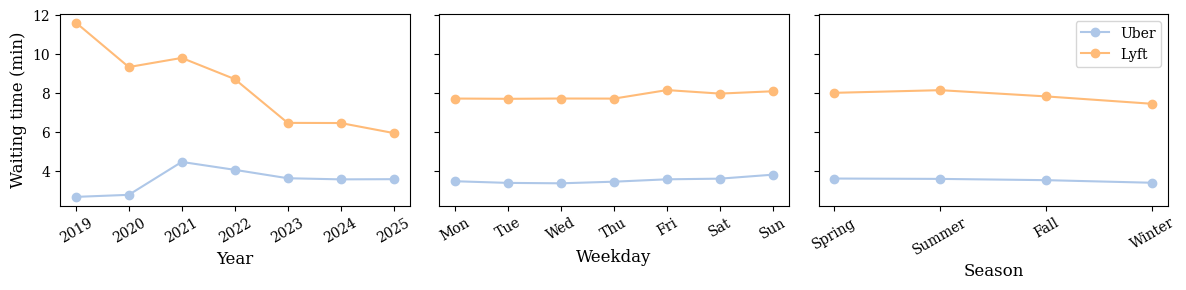

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# File paths
vis_path = Path("/d/hpc/home/jv8043/BD/project/T8/T8_vis")  # <-- Update this with your actual path
services = ["Uber", "Lyft"]

# Read data for both services
data = {}
for service in services:
    data[service] = {
        "year": pd.read_csv(vis_path / f"waiting_time_by_year_{service}.csv").sort_values("year"),
        "weekday": pd.read_csv(vis_path / f"waiting_time_by_weekday_{service}.csv").sort_values("weekday"),
        "season": pd.read_csv(vis_path / f"waiting_time_by_season_{service}.csv")
    }

# Order and sort season
season_order = ["Spring", "Summer", "Fall", "Winter"]
for service in services:
    df = data[service]["season"]
    df["season"] = pd.Categorical(df["season"], categories=season_order, ordered=True)
    data[service]["season"] = df.sort_values("season")

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(12, 3), sharey=True)

colors = {
    "Uber": "#aec7e8",
    "Lyft": "#ffbb78"
}

# Plot by year
for service in services:
    axs[0].plot(data[service]["year"]["year"], data[service]["year"]["waiting_time_min"],
                marker='o', linestyle='-', label=service, color=colors[service])
axs[0].set_xlabel("Year")
axs[0].set_ylabel("Waiting time (min)")
axs[0].set_xticks(sorted(data["Uber"]["year"]["year"].unique()))  # Assuming both have same years
axs[0].set_xticklabels(sorted(data["Uber"]["year"]["year"].unique()), rotation=30)
# axs[0].legend()

# Plot by weekday
weekday_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
for service in services:
    axs[1].plot(data[service]["weekday"]["weekday"], data[service]["weekday"]["waiting_time_min"],
                marker='o', linestyle='-', label=service, color=colors[service])
axs[1].set_xlabel("Weekday")
axs[1].set_xticks(range(7))
axs[1].set_xticklabels(weekday_labels, rotation=30)
# axs[1].legend()

# Plot by season
for service in services:
    axs[2].plot(data[service]["season"]["season"], data[service]["season"]["waiting_time_min"],
                marker='o', linestyle='-', label=service, color=colors[service])
axs[2].set_xlabel("Season")
axs[2].tick_params(axis='x', rotation=30)
axs[2].legend()

fig.tight_layout()
fig.savefig(vis_path / "waiting_time_by_service.pdf", dpi=300, bbox_inches='tight')
plt.show()